### Overview
In this notebook we design and run experiments to evaluate the performance standard models to serve as a baseline.

The models:
1. particle filter


The experiments:
1. generated data, fixed known parameters
2. real world data, parameters estimated

In [2]:
import math
import collections
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
from particle_filter import ParticleFilter
import matplotlib.pyplot as plt
from functools import reduce

import experiment_helpers
from stochastic_volatility import HarveySV, HarveySVParamters

### Generated Data with Fixed, Known Parameters
In this first experiment we first generate data from a simple stochastic volatility model (Harvey 1990) and then try to predict the accuracy.

In [5]:
config = {
    "samples": 125,
    "sequence_length": 300,
    "window_size": 1
}

sv_parameters = HarveySVParamters(
    mu=2. * np.log(.7204), 
    phi=.9807, 
    tau=0.1489
)

xs = []
ys = []

for s in range(config["samples"]):
    volatility, innovations = HarveySV.generate_data(config["sequence_length"], sv_parameters)

    # normalize values to between 0 and 1
    #volatility = normalize(volatility)
    #innovations = normalize(innovations)
    
    # convert to numpy arrays
    volatility = np.array(volatility)
    innovations = np.array(innovations)

    # below we create several windows of observations
    window_size = config["window_size"]
    windows = ( # add arrays together to create sub_windows
        np.expand_dims(np.arange(window_size), 0) +  # time offsets
        np.expand_dims(np.arange(len(innovations) - window_size), 0).T  # start times
    )
    innovation_windows = innovations[windows]

    # get rid of the volatilies for which we do not have enough previous values for
    volatility = volatility[window_size:]

    # reshape volatility to have one output per window 
    volatility = volatility.reshape(len(volatility), 1, )

    # finally we add the arrays to our dataset
    xs.append(innovation_windows)
    ys.append(volatility)

### Defining Our Particle Filter
Now that we have our data we can define our particle filter. Although we have our particle filter class we need to define the specific init, state transition and observation likelihood functions associated.

In [6]:
# function generators
# these will generate any of the functions for a fixed set of parameters
def particle_initializer_generator(params):
    parameters = params
    def particle_initializer(num_particles):
        return [np.random.normal(loc=parameters.mu, scale=parameters.tau) for i in range(0, num_particles)]
    return particle_initializer

def obvs_prob_func(observation, particle):
    return stats.norm.pdf(observation, loc=0, scale=math.exp(0.5 * particle))

def transformation_func_generator(params):
    paramters = params
    def trans_func(particle, control):
        x_mean = parameters.mu + parameters.phi * (particle - parameters.mu)
        x = np.random.normal(loc=x_mean, scale=parameters.tau)
        return x
    return trans_func

# pass in our earlier
Parameters = collections.namedtuple('Parameters', ['mu', 'phi', 'tau'])
parameters = Parameters(mu=2. * np.log(.7204), phi=.9807, tau=0.1489)
trans_func = transformation_func_generator(parameters)

particle_initializer = particle_initializer_generator(parameters)

num_particles = 128

pf = ParticleFilter(trans_func, obvs_prob_func, particle_initializer, num_particles)

### Running Our Experiment
Now we can run our particle filter over all our data and then calculate our evaluation metrics.

In [7]:
test_results = {
    "mse": np.zeros(len(ys)),
    "mae": np.zeros(len(ys)),
    "qlike": np.zeros(len(ys)),
    "mde": np.zeros(len(ys)),
    "log_likelihood": np.zeros(len(ys)),
    "particle_log_likelihood": np.zeros(len(ys)),
} 

results = np.zeros((len(xs), config["sequence_length"] + 1))

for batch_index in range(len(xs)):
    pf.reset()
    if batch_index % 5 == 0:
        print(f"running batch {batch_index}/{len(xs)}")
    innovations = xs[batch_index]
    estimated_volatility = [pf.get_mean_particle()]
    particles = [pf.particles]
    for i in innovations:
        pf.step(i[0], None)
        estimated_volatility.append(pf.get_mean_particle())
    estimated_volatility = np.array(estimated_volatility)
    results[batch_index] = estimated_volatility
    test_results["mse"][batch_index] = experiment_helpers.mse(ys[batch_index][:,0], estimated_volatility[1:])
    test_results["mae"][batch_index] = experiment_helpers.mae(ys[batch_index][:,0], estimated_volatility[1:])
    test_results["qlike"][batch_index] = experiment_helpers.qlike(ys[batch_index][:,0], estimated_volatility[1:])
    test_results["mde"][batch_index] = experiment_helpers.mde(ys[batch_index][:,0], estimated_volatility[1:])
    test_results["log_likelihood"][batch_index] = experiment_helpers.log_likelihood(ys[batch_index][:,0], estimated_volatility[1:], sv_parameters.tau)

running batch 0/125
running batch 5/125
running batch 10/125
running batch 15/125
running batch 20/125
running batch 25/125
running batch 30/125
running batch 35/125
running batch 40/125
running batch 45/125
running batch 50/125
running batch 55/125
running batch 60/125
running batch 65/125
running batch 70/125
running batch 75/125
running batch 80/125
running batch 85/125
running batch 90/125
running batch 95/125
running batch 100/125
running batch 105/125
running batch 110/125
running batch 115/125
running batch 120/125


Then we can print our results

In [8]:
for k, v in test_results.items():
    print(f"mean {k}: {v.mean()}")
    print(f"std  {k}: {v.std()}")

mean mse: 0.22096687430655865
std  mse: 0.0673683662724558
mean mae: 0.37344831260108446
std  mae: 0.059245557838493446
mean qlike: 0.07508768502077535
std  qlike: 2.1929322015395654
mean mde: 0.4978729096989967
std  mde: 0.0245598617665275
mean log_likelihood: -1199.2956109305812
std  log_likelihood: 455.7827444180255
mean particle_log_likelihood: 0.0
std  particle_log_likelihood: 0.0


In [8]:
estimated_volatility.shape

(301,)

### Real World Data with Parameters Estimated
Here we take a real world dataset of volatility that we have created/calculated ourselves. We then estimate the parameters of our stochastic volatility model and then use those to generate our particle filter. Finally we run our experiments using that particle filter.

In [36]:
# load our volatility dataset
volatility_df = pd.read_csv("./volatility_data/AAPL_daily_vol.csv")
volatility_data = volatility_df['volatility'].to_numpy()

Now we need to define our likelihood function and volatility function

In [10]:
def volatility_model(params, prev_vol):
    mu, tau, phi = params

    predicted_volatility = mu + phi * (prev_vol - mu)

    return predicted_volatility

def log_likelihood(params, data):
    n = len(data)
    ll = 0.0

    mu, tau, phi = params
    
    # Iterate over the data to calculate the log-likelihood
    for i in range(1, n):
        predicted_volatility = volatility_model(params, data[i-1])
        log_prob = np.log(stats.norm.pdf(data[i], loc=predicted_volatility, scale=tau))
        ll += log_prob
    
    return -ll

Finally we use the minimize function from scipy. This performs MLE to find the most optimal paramters.

In [23]:
def fit(data, initial_params):

    # Optimization using MLE
    result = minimize(log_likelihood, initial_params, args=(np.sqrt(volatility_data),), method='Nelder-Mead')

    # Extract the optimized parameter values
    optimal_params = result.x
    ll = result.fun

    return (optimal_params, ll)

In [38]:
best_params = None
max_ll = -10000
for mu in [-0.35, -0.25, -0.1, 0, 0.05]:
    for tau in [0.02, 0.03, 0.04, 0.05]:
        for phi in [ 0.5, 0.7,0.9]:
            params, ll = fit(volatility_data, [mu, tau, phi])
            if ll > max_ll and ll < 100:
                print("ll: ", ll)
                print("params: ", params)
                print("init: ", (mu, tau, phi))
                best_params = params
                max_ll = ll

ll:  -480.05980429987346
params:  [0.25626514 0.03492473 0.93012022]
init:  (-0.35, 0.02, 0.5)
ll:  -475.58000732890054
params:  [-6.32784493e+02  3.55602560e-02  1.00000190e+00]
init:  (-0.35, 0.02, 0.9)
ll:  -475.451903726751
params:  [-0.15908652  0.03556891  0.99905159]
init:  (-0.35, 0.03, 0.7)
ll:  -475.4376275425461
params:  [-0.33498892  0.03557695  1.0001412 ]
init:  (-0.35, 0.03, 0.9)
ll:  -475.43743504237653
params:  [-0.32908586  0.03557508  1.00012051]
init:  (-0.35, 0.04, 0.9)


We found the best paramters to be [0.3413335  0.00439982 0.99999095] after grid searching

### Defining the Particle Filter
Now that we have found our optimal paramters we are going to define our particle filter.

We define our transformation, likelihood and initialization functions based off the Harvey 1990 model.

In [73]:
# function generators
# these will generate any of the functions for a fixed set of parameters
def particle_initializer_generator(params):
    parameters = params
    def particle_initializer(num_particles):
        return [np.random.normal(loc=parameters.mu, scale=4*parameters.tau) for i in range(0, num_particles)]
    return particle_initializer

def obvs_prob_func(observation, particle):
    return stats.norm.pdf(observation, loc=0, scale=math.exp(2*particle))

def transformation_func_generator(params):
    parameters = params
    def trans_func(particle, control):
        x_mean = parameters.mu + parameters.phi * (particle - parameters.mu)
        x = np.random.normal(loc=x_mean, scale=parameters.tau)
        return x
    return trans_func

# pass in our earlier
Parameters = collections.namedtuple('Parameters', ['mu', 'phi', 'tau'])
parameters = Parameters(mu=0.3413335, phi=0.99999095, tau=0.00439982)
trans_func = transformation_func_generator(parameters)

particle_initializer = particle_initializer_generator(parameters)

num_particles = 100

pf = ParticleFilter(trans_func, obvs_prob_func, particle_initializer, num_particles)

below as a little test we run an experiment with generated data. Our real goal is to run the experiment with real world data.

In [74]:
n = 400

params = HarveySVParamters(
    0.3413335,
    0.00439982,
    0.99999095
)

volatility, innovations = HarveySV.generate_data(timesteps=n, parameters=params)

estimated_volatility = [pf.get_mean_particle()]
particles = [pf.particles]
for i in innovations:
    pf.step(i, None)
    particles.append(pf.particles)
    estimated_volatility.append(pf.get_mean_particle())

Now lets plot 

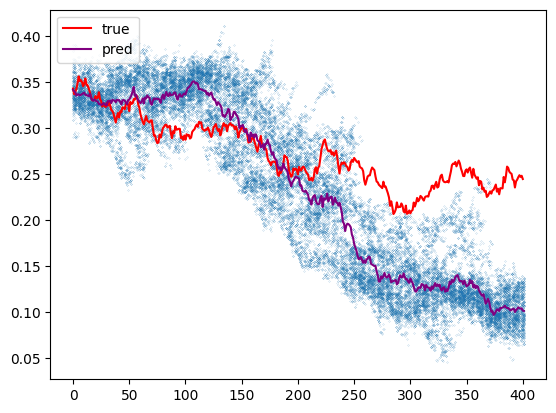

In [75]:
x = reduce(lambda x, y: x+y, particles)
y = reduce(lambda x, y: x+y, [[i] * num_particles for i in range(0, len(particles))])
plt.scatter(y, x, s=0.01)
plt.plot(volatility, color="red", label="true")
plt.plot(estimated_volatility, color="purple", label="pred")
plt.legend(loc="upper left")
#plt.ylim(-3.5, 1.4)
plt.show()

We now run the particle filter on real world data.

Note we redefine the initialization function to start vola